In [2]:
import cv2

import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from keras import models, layers, optimizers
from keras.layers import Input, Dense
from keras.models import Model

from pathlib import Path

from vis.utils import utils
import keras.backend as K

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
weights = Path('C:/Users/npurk/Desktop/VAE/monkey_model.h5')
train_dir = Path('C:/Users/npurk/Desktop/VAE/training/')
test_dir = Path('C:/Users/npurk/Desktop/VAE/validation/')

In [4]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("C:/Users/npurk/Desktop/VAE/monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


(367, 550, 3)


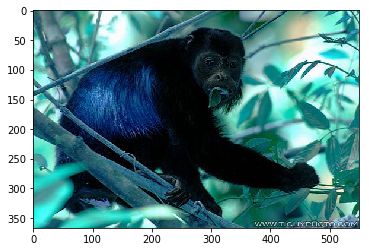

In [5]:
img = cv2.imread('C:/Users/npurk/Desktop/VAE/training/n0018.jpg')
print(img.shape)
plt.imshow(img);

In [6]:
import os

all_monkeys = []
for image in os.listdir(train_dir):
    try:
        monkey = utils.load_img(('C:/Users/npurk/Desktop/VAE/training/' + image), target_size=(64,64))
        all_monkeys.append(monkey)
    except Exception as e:
        pass
    
print('Recovered data format:', type(all_monkeys))    
print('Number of monkey images:', len(all_monkeys))
    

D:\Anaconda\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Recovered data format: <class 'list'>
Number of monkey images: 1094


In [7]:
# Make into array
all_monkeys = np.asarray(all_monkeys)
print('Shape of array:', all_monkeys.shape)

# Normalize pixel values
all_monkeys = all_monkeys.astype('float32') / 255.



Shape of array: (1094, 64, 64, 3)


In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train , y_test = train_test_split(all_monkeys, all_monkeys, test_size=0.2, random_state=42)

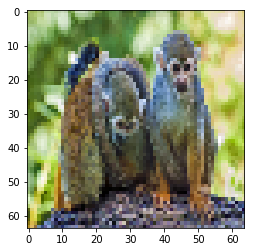

In [10]:
plt.imshow(x_train[3])

In [56]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D

# Input Placeholder
input_img = Input(shape=(64, 64, 3))  # adapt this if using `channels_first` image data format

# Encoder part
l1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
l2 = MaxPooling2D((2, 2), padding='same')(l1)
l3 = Conv2D(16, (3, 3), activation='relu', padding='same')(l2)

# Latent Space, with dimension (None, 32, 32, 16)
encoded = MaxPooling2D((1,1), padding='same')(l3) 


# Decoder Part
l8 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
l9 = UpSampling2D((2, 2))(l8)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(l9)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 64, 16)        0         
__________

In [64]:
# Choose noise factor

noise_factor = 0.35

# Define noisy versions
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# CLip values between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

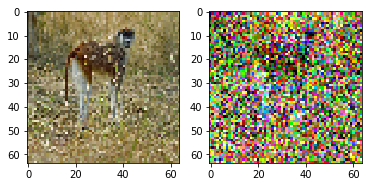

In [74]:
# Effect of adding noise factor
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(x_test[1])

f.add_subplot(1,2, 2)
plt.imshow(x_test_noisy[1])

plt.show(block=True)

In [60]:
autoencoder.compile(optimizer='adam', loss='mse')

In [61]:
autoencoder.fit(x_train_noisy, x_train, epochs=50, batch_size=20,
               shuffle=True, verbose=1)


Epoch 1/50
875/875 [==============================] - 7s 8ms/step - loss: 0.0449
Epoch 2/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0212
Epoch 3/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0185
Epoch 4/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0169
Epoch 5/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0162
Epoch 6/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0157
Epoch 7/50
875/875 [==============================] - 6s 7ms/step - loss: 0.0151
Epoch 8/50
875/875 [==============================] - 7s 8ms/step - loss: 0.0146
Epoch 9/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0143
Epoch 10/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0141A:
Epoch 11/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0140
Epoch 12/50
875/875 [==============================] - 8s 9ms/step - loss: 0.0138
Epoch 13/50
875/875 [==

In [75]:
def compare_outputs(x_test, decoded_imgs=None, n=10):
    plt.figure(figsize=(22, 5))
    
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test_noisy[i].reshape(64,64,3))
        plt.gray()

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_imgs is not None:
            ax = plt.subplot(2, n, i+ 1 +n)
            plt.imshow(decoded_imgs[i].reshape(64,64,3))

            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            
    plt.show()

Upper row: Input image provided 
Bottom row: Decoded output generated


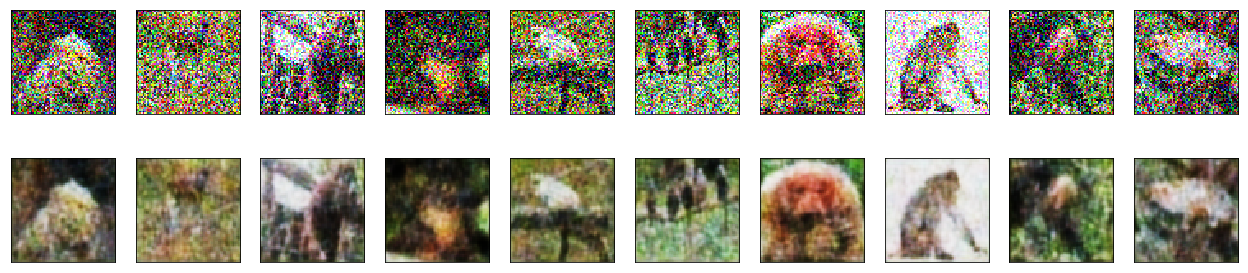

In [76]:
decoded_imgs = autoencoder.predict(x_test_noisy)
print('Upper row: Input image provided \nBottom row: Decoded output generated')
compare_outputs(x_test, decoded_imgs)

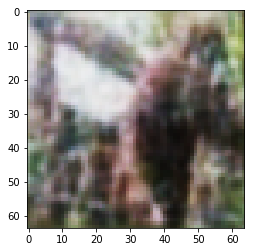

In [80]:
plt.imshow(decoded_imgs[2])

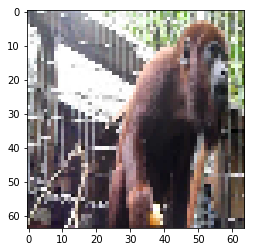

In [82]:
plt.imshow(x_test[2])